In [2]:
from random import randint
import copy
import numpy as np
import random
import heapq
from itertools import islice
import networkx as nx
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'networkx'

# QL Agent

In [2]:
class QLA:
    
    def __init__(self, router, N, L, DAGs, learning_rate, discount_factor):
        self.N = N
        self.router = router
        self.DAGs = DAGs # ogni DAG è una lista con i links appartenenti ad esso
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.L = L
        self.Q_table = {} # le righe si riferiscono alle diverse destinazioni nei vari DAGs, le colonne sono i link della rete. NON È LA CLASSICA MATRICE Q
        self.initialize_Q_table()
    
    def initialize_Q_table(self):
        links = []
        for interface in self.router.interfaces:
            if self.router.interfaces[interface].link != None:
                links.append(self.router.interfaces[interface].link.linkID)
        for n in self.DAGs: #range(N):
            if n != self.router.name:
                tmp = -10000 * np.ones((self.L, 1))
                for link in links:
                    if link in self.DAGs[n]:
                        tmp[link] = 0
                self.Q_table[n] = tmp
            else:
                self.Q_table[n] = np.zeros((self.L, 1))
    
    def insert_payload(self, pkt):
        payload = Payload(self.router.name, self.Q_table)
        pkt.set_payload(payload)
        return pkt
    
    def get_reward(self, pkt):
        ifaces = pkt.position.interfaces
        router_NICs = pkt.position.interfaces
        for iface in ifaces:
            if router_NICs[iface].link.head == pkt.pred:
                #assegna reward in base ad accodamento su iface
                queue_len = len(router_NICs[iface].queue)
                reward = self.calcola_reward(queue_len)
                return reward
            
    
    def explore(self, pkt):
        payload = pkt.payload
        router_NICs = self.router.interfaces
        for interface in router_NICs:
            head = router_NICs[interface].link.head.name
            if head == payload.node_ID:
                link = router_NICs[interface].link.linkID
                break
        for n in self.DAGs:
            if n != self.router.name:
                if link in self.DAGs[n]:
                    q_values_neighbor = np.max(payload.Q_value_rows[n])
                    reward = self.get_reward(pkt)
                    q_value_local = self.Q_table[n][link]
                    self.Q_table[n][link] = q_value_local + self.learning_rate * (reward + self.discount_factor * q_values_neighbor - q_value_local)                        
            
    def exploit(self, pkt):
        tmp = self.Q_table[pkt.destinazione]
        out_link_ID = np.argmax(tmp)
        router_NICs = pkt.position.interfaces
        for interface in router_NICs:
            if router_NICs[interface].link.linkID == out_link_ID:
                return router_NICs[interface]
        
    def calcola_reward(self, queue_len):
        return -queue_len - 1
    
    

# Packet

In [3]:
class Packet:
    
    def __init__(self, length, source, time0, flow_ID, SN, destination):
        self.length = length # in byte
        self.time0 = time0 # when the packet is created
        self.position = source # current interface or router
        self.flow_ID = flow_ID
        self.pathID = -1
        self.SN = SN
        self.destinazione = destination # usare nome router
        self.payload = None
        self.pred = None # router predecessore
        self.hop_count = 0
        self.path = ""
    
    def set_payload(self, payload):
        self.payload = payload

class Payload:
    
    def __init__(self, node_ID, Q_value_rows):
        self.node_ID = node_ID
        self.Q_value_rows = Q_value_rows # è l'attributo Q_table dell'oggetto QLA

# Router

In [4]:
class Router:
    
    def __init__(self, name):
        self.name = name # assegnare un intero tra 0 ed N-1
        self.routingTable = {} # <key: dst/flow_id; value: out_interface>
        self.interfaces = {}
        self.log = None
        self.QL_agent = None
    
    def set_QL_agent(self, agent):
        self.QL_agent = agent
    
    def addLogFile(self, log):
        self.log = log
    
    def addInterface(self, interface):
        self.interfaces[interface.name] = interface
        
    def forward(self, pkt):
        if pkt.flow_ID in self.routingTable:
            if self.routingTable[pkt.flow_ID] == 'QL':
                out_interface = self.QL_agent.exploit(pkt)
            else:
                out_interface = self.routingTable[pkt.flow_ID]
        elif pkt.destinazione in self.routingTable:
            if self.routingTable[pkt.destinazione] == 'QL':
                out_interface = self.QL_agent.exploit(pkt)
            else:
                out_interface = self.routingTable[pkt.destinazione]
        else: 
            if self.routingTable['default'] == 'QL':
                out_interface = self.QL_agent.exploit(pkt)
            else:
                out_interface = self.routingTable['default']
        pkt = self.QL_agent.insert_payload(pkt)
        #if out_interface != 'local' and self.name == 0:
            #print(out_interface.name)
        return out_interface, pkt

    def receivePkt(self, event):
        global sim_time
        pkt = event.object
        scheduler = event.scheduler
        if pkt.payload != None:
            self.QL_agent.explore(pkt)
        out_interface, pkt = self.forward(pkt)
        pkt.position = out_interface
        pkt.hop_count += 1
        pkt.path += str(self.name) + ","
        if out_interface != 'local':
            out_interface.receivePkt(pkt, scheduler)
        if self.log != None:
            base_msg = str(pkt.flow_ID) + '\t ' + str(pkt.SN) + '\t ' + str(pkt.time0) + '\t ' + str(sim_time) + '\t ' + str(pkt.destinazione) + '\t' + str(pkt.hop_count) + '\t' + pkt.path + '\t'
            self.log.write_log(base_msg + 'RX' + ' \n')

# Link & Interface

In [5]:
class Link:
    
    def __init__(self, head, tail, delay, linkID):
        self.linkID = linkID # numerico ... da mettere in relazione alle colonne della matrice Q
        self.head = head # next router
        self.tail = tail # interface
        self.delay = delay * 10 ** -3 # ms
        tail.connect(self)

class Interface:
    
    def __init__(self, router, name, rate, queue_size):
        global sim_time
        self.last_tx = sim_time
        self.link = None
        self.when_free = 0
        self.queue = []
        self.router = router
        self.name = name
        self.rate = rate * 10 ** 6 # Mbps
        self.queue_size = queue_size # number of packets
        self.dropped = 0
        self.TX_byte_counter = 0
        self.TX_destinazione = {}
        if router != None:
            router.addInterface(self)
    
    def connect(self, link):
        self.link = link
        
    def getNextRouter(self):
        return self.link.head
    
    def transmit(self, pkt, scheduler):
        global sim_time
        self.last_TX = sim_time
        Ttx = sim_time + float(pkt.length * 8) / float(self.rate)
        self.when_free = Ttx
        pkt.position = self.getNextRouter()
        pkt.pred = self.router
        event = Event(pkt, Ttx + self.link.delay, "router RX pkt", scheduler)
        scheduler.addEvent(event)
        #self.TX_byte_counter += pkt.length
        #event = Event(self, Ttx, "TX completed")
        #scheduler.addEvent(event)
        
    def removeFromQueue(self, event):
        pkt = event.object
        scheduler = event.scheduler
        self.queue.remove(pkt)
        self.transmit(pkt, scheduler)
        
    def receivePkt(self, pkt, scheduler):
        global sim_time
        self.TX_byte_counter += pkt.length
        if pkt.destinazione != None:
            if pkt.destinazione in self.TX_destinazione:
                self.TX_destinazione[pkt.destinazione] += pkt.length
            else:
                self.TX_destinazione[pkt.destinazione] = pkt.length
        if len(self.queue) + 1 <= self.queue_size:
            if self.when_free <= sim_time and len(self.queue) == 0:
                # START TX CURRENT PKT
                self.transmit(pkt, scheduler)
            else:
                queue_len_bit = 0
                for pp in self.queue:
                    queue_len_bit += pp.length * 8
                Ttx = self.when_free + float(queue_len_bit) / float(self.rate)
                self.queue.append(pkt)
                event = Event(pkt, Ttx, "remove from queue", scheduler)
                scheduler.addEvent(event)
        else:
            self.dropped = self.dropped + 1
            if self.router.log != None:
                messaggio = str(pkt.flow_ID) + '\t ' + str(pkt.SN) + '\t ' + '\t ' + str(pkt.time0) + '\t' + str(sim_time * 10 ** 3) + '\t '
                self.router.log.write_log(messaggio + 'PKT DROPPED' + ' \n') 

# Event & Scheduler

In [6]:
class Event:
    
    def __init__(self, obj, when, what, scheduler):
        self.object = obj
        self.when = when
        self.what = what # 2) router RX pkt - 1) remove from queue - 3) reroute - 4) collect stats
        self.scheduler = scheduler
        
    def do_remove_from_queue(self):
        self.object.position.removeFromQueue(self)
        
    def do_router_RX_pkt(self):
        self.object.position.receivePkt(self)
        
    def do_reroute(self):
        router = self.object[0]
        router.routingTable[self.object[1]] = self.object[2]
        
    def do_collect_stats(self): #obj: statsCollector
        self.object.collectStats()

class Scheduler:
    
    def __init__(self):
        self.events = {}
        self.chiaveTempi = []

    def addEvent(self, event):
        if event.when in self.events.keys():
            self.events[event.when].append(event)
        else:
            self.events[event.when] = [event]
            heapq.heappush(self.chiaveTempi, event.when)

    def delOldEvents(self):
        global sim_time
        self.events.pop(sim_time)

    def nextEvents(self):
        global sim_time
        sim_time = heapq.heappop(self.chiaveTempi)
        #sim_time = min(self.events.keys())
        tmp = self.events[sim_time]
        next_events = []
        for event in tmp:
            if event.what == 'remove from queue':
                next_events.append(event)
        for event in tmp:
            if event.what == 'router RX pkt':
                next_events.append(event)
        for event in tmp:
            if event.what == 'reroute':
                next_events.append(event)
        for event in tmp:
            if event.what == 'collect stats':
                next_events.append(event)
        return next_events

    def sim_status(self):
        if len(self.events.keys()) == 0:
            return False
        else:
            return True

    def run(self):
        while self.sim_status():
            nextEvents = self.nextEvents()
            for event in nextEvents:
                if event.what == 'remove from queue':
                    event.do_remove_from_queue()
                if event.what == 'router RX pkt':
                    event.do_router_RX_pkt()
                if event.what == 'reroute':
                    event.do_reroute()
                if event.what == 'collect stats':
                    event.do_collect_stats()
            self.delOldEvents()

# statsCollector & TrafficGenerator & Log

In [7]:
class statsCollector:
    
    def __init__(self, file_name, list_of_devices, period, duration, scheduler):
        self.file_name = file_name
        self.devices = list_of_devices # contiene la lista di interfacce da monitorare
        self.queue_stats = 'TIME\t DEVICE\t QUEUE_LEN\n'
        self.tx_stats = 'TIME\t DEVICE\t # TX\n'
        self.dropped = 'TIME\t DEVICE\t # DROP\n'
        self.scheduleStatsCollection(scheduler, period, duration)

    def collectStats(self):
        global sim_time
        for device in self.devices:
            msg = str(sim_time) + '\t' + device.name + '\t' + str(len(device.queue)) + '\n'
            self.queue_stats = self.queue_stats + msg
            msg = str(sim_time) + '\t' + device.name + '\t' + str(device.TX_byte_counter) + '\n'
            self.tx_stats = self.tx_stats + msg
            msg = str(sim_time) + '\t' + device.name + '\t' + str(device.dropped) + '\n'
            self.dropped = self.dropped + msg

    def scheduleStatsCollection(self, scheduler, period, duration):
        for tt in np.arange(0, duration + period, period):
            e = Event(self, tt, 'collect stats', scheduler)
            scheduler.addEvent(e)

    def stampaSuFile(self):
        with open(self.file_name + "_QUEUE_LEN.txt", "w+") as a:
            lines = self.queue_stats.split('\n')
            for line in lines:
                if len(line) > 1:
                    a.write(line + '\n')
        with open(self.file_name + "_TX_STATS.txt", "w+") as a:
            lines = self.tx_stats.split('\n')
            for line in lines:
                if len(line) > 1:
                    a.write(line + '\n')
        with open(self.file_name + "_DROPPED_STATS.txt", "w+") as a:
            lines = self.dropped.split('\n')
            for line in lines:
                if len(line) > 1:
                    a.write(line + '\n')


class TrafficGenerator: # TG si aggancia ad una scheda di rete (source)
    
    def __init__(self, flow_ID, destination, source, duration, packet_size, start_time, scheduler):
        self.bitRate = source.rate
        self.Ttx = packet_size * 8.0 / self.bitRate
        self.numPacchetti = int(duration / self.Ttx)
        self.flow_id = flow_ID
        SN = 1
        for p in range(1, self.numPacchetti + 1):
            pkt = Packet(packet_size, source.getNextRouter(), start_time + p * self.Ttx, flow_ID, SN, destination) # source e' la scheda alla quale e' agganciato TG, quindi la posizione del pacchetto deve essere impostata al prossimo salto (router estremo del link)
            SN += 1
            event = Event(pkt, start_time + p * self.Ttx + source.link.delay, "router RX pkt", scheduler)
            scheduler.addEvent(event)

class TrafficBurst:
    def __init__(self, flow_ID, destination, source, activity_ratio, period, duration, packet_size, start_time, scheduler):
        self.maxRate = source.rate
        self.Ttx = packet_size * 8.0 / self.maxRate
        self.burst_duration = period * activity_ratio
        self.burst_length = int(self.burst_duration / self.Ttx)
        self.number_of_cycles = int(float(duration) / float(period))
        self.flow_id = flow_ID
        SN = 1
        for c in range(1, self.number_of_cycles):
            for p in range(1, self.burst_length + 1):
                pkt = Packet(packet_size, source.getNextRouter(), start_time + (c - 1) * period + p * self.Ttx, flow_ID, SN, destination)
                SN += 1
                event = Event(pkt, start_time + (c - 1) * period + p * self.Ttx + source.link.delay, "router RX pkt", scheduler)
                scheduler.addEvent(event)

class TG_pcap:
    
    def __init__(self, nome_file, source, scheduler, num_destinazioni, num_cicli, durata_max, inizio, black_list):
        self.nome_file = nome_file
        self.source = source
        self.scheduler = scheduler
        self.num_destinazioni = num_destinazioni
        self.time_last_pkt = 0
        self.num_cicli = num_cicli
        self.durata_max = durata_max
        self.inizio = inizio
        self.black_list = black_list
        self.importa_traccia()
    
    def importa_traccia(self):
        flows = {}
        flow_IDs = {}
        destinazioni = {}
        bitRX = []
        timeRX = []
        fid = 0
        with open(self.nome_file, "r") as a:
            trace = a.readlines()
        for ciclo in range(0, self.num_cicli):
            for line in trace:
                tmp = line.split()
                if len(tmp) == 8 and ',' not in tmp[2] and float(tmp[0]) < self.durata_max and float(tmp[0]) >= self.inizio:
                    flow = tmp[3] + "_" + tmp[4] + "_" + tmp[5] + "_" + tmp[6] + "_" + tmp[7]
                    bitRX.append(int(tmp[2]) * 8)
                    timeRX.append(float(tmp[0]))
                    if flow not in flows:
                        fid += 1
                        flow_IDs[flow] = fid
                        flows[flow] = 0
                        if self.num_destinazioni > 0:
                            destinazioni[flow] = str(randint(1, self.num_destinazioni)) # l'id di una destinazione e' un intero convertito in stringa
                        else:
                            flows[flow] += 1
                        pkt = Packet(int(tmp[2]), self.source.getNextRouter(), ciclo * self.time_last_pkt + float(tmp[0]), flow_IDs[flow], flows[flow])
                        if flow in destinazioni:
                            pkt.destinazione = destinazioni[flow]
                        if pkt.destinazione not in self.black_list:
                            event = Event(pkt, ciclo * self.time_last_pkt + float(tmp[0]) + self.source.link.delay, "router RX pkt", scheduler)
                            self.scheduler.addEvent(event)
            self.time_last_pkt = float(tmp[0])
        self.flows = flows
        self.bitRX = bitRX
        self.timeRX = timeRX

class Log:
    
    def __init__(self, name):
        self.message = 'FLOW_ID\t SN\t TIME_0\t TIME\t DESTINATION\t HOP_COUNT\t PATH\t EVENT\n'
        self.name = name
        
    def write_log(self, msg):
        self.message = self.message + msg
        
    def stampa_su_file(self):
        with open(self.name + ".txt", "w+") as a:
            lines = self.message.split('\n')
            for line in lines:
                a.write(line + '\n')


In [8]:
def importa_file_log(file_name):

    risultati = []

    with open(file_name, 'r') as file:
        for line in file:
            risultati.append(line.split())

    rows = len(risultati)
    columns = 7

    results = np.zeros((rows, columns))

    for r in range(rows):
        if len(risultati[r]) > 2:
            if risultati[r][-1] == 'RX':
                results[r, 0] = int(risultati[r][0]) # flow_id
                results[r, 1] = int (risultati[r][1]) # sequence number
                results[r, 2] = float(risultati[r][2]) # time 0
                results[r, 3] = float(risultati[r][3]) # end time
                results[r, 4] = int(risultati[r][4]) # destination ID
                results[r, 5] = int(risultati[r][5]) # hop_count
                results[r, 6] = results[r, 3] - results[r, 2] # delay
    
    return results

def importa_file_collector(file_name, devices):

    risultati = []

    with open(file_name, 'r') as file:
        for line in file:
            risultati.append(line.split())

    stats = {}
    
    for device_name in devices:
        stats[device_name] = [[0], [0]]
        
    for r in range(1,len(risultati)):
        if len(risultati[r]) == 3:
            if risultati[r][1] in devices:
                tmp = stats[risultati[r][1]]
                tmp1 = tmp[0]
                tmp2 = tmp[1]
                tmp1.append(float(risultati[r][0]))
                tmp2.append(int(risultati[r][2]))
    
    return stats

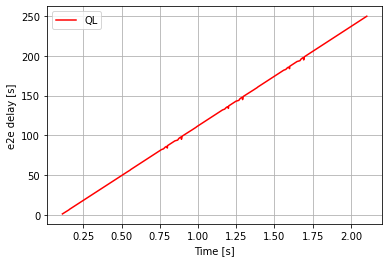

In [150]:
# QUESTO SCRIPT PUÒ ESEGUIRE IL PLOT DI DIVERSI PARAMETRI ALL'INTERNO DEL FILE DI LOG


file_name = 'GOAL_log.txt'
flow_IDs = [1234]

tmp = old_results
#old_results = {}

matrix = importa_file_log(file_name)

# Select the column to plot (e.g., the second column, index 1)
column_index = 1 # 0) flowID; 1) SN; 2) start_time; 3) end_time; 4) dest_ID; 5) hop_count; 6) e2e delay

#fig, axs = plt.subplots(len(flow_IDs), 1, figsize=(8, 6))
index = 0

for fid in flow_IDs:
    
    y_data = matrix[matrix[:, 0] == fid, column_index]
    x_data = matrix[matrix[:, 0] == fid, 3]

    # Plot the column data

    plt.plot(x_data, y_data, color='r', label="QL")
    #axs[index].plot(x_data, y_data, color='r')
    #axs[index].plot(tmp[fid][0], tmp[fid][1], color='b')
    #plt.plot(tmp[fid][0], tmp[fid][1], color='b', label="SP")
    
    #old_results[fid] = [x_data, y_data]
    
    index += 1


plt.xlabel('Time [s]')
plt.ylabel('e2e delay [s]')
plt.grid(True)
#plt.tight_layout()
plt.legend()

#plt.savefig('e2e.pdf', format='pdf')
plt.show()

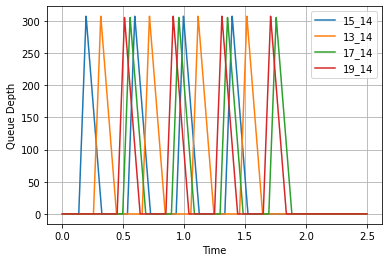

In [86]:
# QUESTO SCRIPT ESEGUE IL PLOT DELL'OCCUPAZIONE DELLE CODE

file_name = 'DAG_ifaces_stats_QUEUE_LEN.txt'
devices = ["15_14", "13_14", "17_14", "19_14"]

stats = importa_file_collector(file_name, devices)

for device_name in devices:
    plt.plot(stats[device_name][0], stats[device_name][1], label=device_name)

plt.legend()
plt.xlabel('Time')
plt.ylabel('Queue Depth')
plt.grid(True)
plt.savefig('queue.pdf', format='pdf')

plt.show()

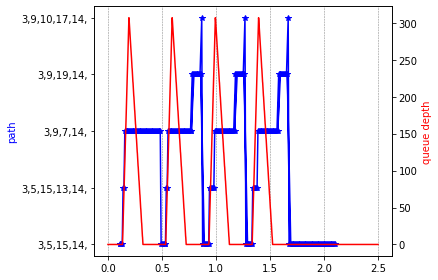

{'3,5,15,14,': 0, '3,5,15,13,14,': 1, '3,9,7,14,': 2, '3,9,19,14,': 3, '3,9,10,17,14,': 4}


In [89]:
# QUESTA FUNZIONE CONSENTE DI ESEGUIRE IL PLOT DELLA VARIAZIONE DEI PERCORSI E CORRELARLO CON IL PLOT
# DELL'OCCUPAZIONE DI BUFFER

def plot_paths(file_name, flow_id, old_x_axis, old_y_axis, filtro):

    risultati = []
    Ttx = 8000/20000000
    Tprop = 0.001

    with open(file_name, 'r') as file:
        for line in file:
            risultati.append(line.split())

    paths = {}
    path_id = 0
    
    x_axis = []
    y_axis = []

    for r in range(len(risultati)):
        if len(risultati[r]) > 2:
            if risultati[r][-1] == 'RX' and int(risultati[r][0]) == flow_id:
                path = risultati[r][-2]
                if path not in paths:
                    paths[path] = path_id
                    path_id += 1
                if filtro != None:
                    if float(risultati[r][2]) >= filtro[0] and float(risultati[r][2]) <= filtro[1]:
                        x_axis.append(float(risultati[r][2])+ Ttx + Tprop)
                        y_axis.append(paths[path])
                else:
                    x_axis.append(float(risultati[r][2]))
                    #y_axis.append(paths[path])
                    y_axis.append(path)
    
    fig, ax1 = plt.subplots()
    yticks_labels = ['3,5,15,14', '3,5,15,13,14', '3,9,7,14', '3,9,19,14', '3,9,10,17,14']
    ax1.plot(x_axis, y_axis, color='blue', label='path', marker='*')
    ax1.set_ylabel('path', color='b')
    #ax1.set_yticks(y_axis)
    #ax1.set_yticklabels(yticks_labels)
    #ax1.legend()
    
    
    if old_x_axis != None:
        ax2 = ax1.twinx()
        if filtro != None:
            tmp_x = np.array(old_x_axis)
            tmp_y = np.array(old_y_axis)
            mask = np.logical_and(tmp_x >= filtro[0], tmp_x <= filtro[1])
            ax2.plot(tmp_x[mask], tmp_y[mask], color='red')
        else:
            ax2.plot(old_x_axis, old_y_axis, color='red', label="queue")
    
    fig.tight_layout()
    ax1.grid(True, axis='x', linestyle='--', linewidth=0.5, color='grey')
    if old_x_axis != None:
        ax2.grid(True, axis='x', linestyle='--', linewidth=0.5, color='grey')
        ax2.set_ylabel('queue depth', color='r')
    
    #plt.legend()
    plt.savefig('path_analysis.pdf', format='pdf')
    plt.show()
    
    return paths, x_axis, y_axis

stats = importa_file_collector('DAG_ifaces_stats_QUEUE_LEN.txt', monitored_interfaces_names)
file_name = 'GOAL_log.txt'
flow_id = 1234
iface_name = "15_14"

#paths_SP, x_axis_SP, y_axis_SP = plot_paths(file_name, flow_id, None, None, None)
paths_QL, x_axis_QL, y_axis_QL = plot_paths(file_name, flow_id, stats[iface_name][0], stats[iface_name][1], None)
#paths_QL, x_axis_QL, y_axis_QL = plot_paths(file_name, flow_id, None, None, None)

print(paths_QL)

In [25]:
def DAG_da_SNDlib(nome_rete, K):

    G_base, N = importa_SNDlib(nome_rete)
    G_dag, N, GOAL = costruisci_DAG(N, G_base, K)
    
    return G_dag, G_base, N, GOAL

def DAG_da_random(N, k, p, K):

    # Parameters
    #N = 10 # number of nodes
    #k = 4   # each node is joined with its k nearest neighbors in a ring topology
    #p = 0.5  # probability of rewiring each edge

    # Generate a Watts-Strogatz graph
    G_base = nx.watts_strogatz_graph(N, k, p)
    G_dag, N, GOAL = costruisci_DAG(N, G_base, K)
    
    return G_dag, G_base, N, GOAL

def costruisci_DAG(N, G_base, K):

    G_dag = nx.DiGraph()
    G_dag.add_nodes_from(range(N))

    lengths = dict(nx.all_pairs_shortest_path_length(G_base))

    max_distance = 0
    farthest_pair = None

    for node1, dists in lengths.items():
        for node2, dist in dists.items():
            if dist > max_distance:
                max_distance = dist
                farthest_pair = (node1, node2)

    GOAL = farthest_pair[1]
    starting_node = farthest_pair[0]

    keys = range(N)
    cycles = {key: [] for key in keys}
    
    paths=nx.shortest_simple_paths(G_base, starting_node, GOAL, weight='weight')

    paths = list(islice(paths, K))
        
    cycles, G_dag = check_all_paths(cycles, paths, starting_node, G_dag)

    for source in range(N):
        print(source)
        if source != starting_node:
            paths = nx.shortest_simple_paths(G_base, source, GOAL, weight='weight')
            paths = list(islice(paths, K))
            cycles, G_dag = check_all_paths(cycles, paths, source, G_dag)

    return G_dag, N, GOAL
    
    

def check_all_paths(cycles, paths, source, G):
    
    for path in paths:
        cycles, G = check_path(cycles, path, source, G)
        
    return cycles, G
    
    
def check_path(cycles, path, source, G):
    
    check = 0
    
    for i in range(len(path)):
        node = path[i]
        for n in range(i+1,len(path)):
            if node in cycles[path[n]]:
                check = 1
                break
        if check == 1:
            break
    
    if check == 0:
        for i in range(len(path)):
            for j in range(i+1,len(path)):
                if path[j] not in cycles[path[i]]:
                    cycles[path[i]].append(path[j])
        for i in range(len(path)-1):
            edge = (path[i], path[i+1])
            if G.has_edge(edge[0], edge[1]) == False:
                G.add_edge(edge[0], edge[1], weight=1)
    
    return cycles, G

def importa_SNDlib(nomeRete="abilene"):

    with open(nomeRete + ".txt", "r") as a:
        data = a.readlines()

    G_base = nx.DiGraph()
    check = 0
    nodi = {}
    n = 0

    for line in data:
        if "NODES" in line:
            check = 1
        if check == 1:
            words = line.split()
            if words[0] == ")":
                check = 0
            if words[0] != "NODES" and check == 1:
                nodi[words[0]] = str(n)
                n += 1

    G_base.add_nodes_from(range(len(nodi)))
    check = 0
    l = 1
    duplicati = {}

    for line in data:
        if "LINKS" in line:
            check = 1
        if check == 1:
            words = line.split()
            if words[0] == ")":
                check = 0
            if words[0] != "LINKS" and check == 1:
                Lij = nodi[words[2]] + "_" + nodi[words[3]]
                Lji = nodi[words[3]] + "_" + nodi[words[2]]
                print(Lij)
                print(Lji)
                if Lij not in duplicati:
                    duplicati[Lij] = 1
                    print(Lij)
                    G_base.add_edge(int(nodi[words[2]]), int(nodi[words[3]]), weight=1)
                    l += 1
                if Lji not in duplicati:
                    duplicati[Lji] = 1
                    print(Lji)
                    G_base.add_edge(int(nodi[words[3]]), int(nodi[words[2]]), weight=1)
                    l += 1
                        
    return G_base, len(nodi)

(3, 5) blue
(3, 9) green
(5, 15) blue
(7, 14) green
(9, 7) green
(9, 19) orange
(9, 10) magenta
(10, 17) magenta
(13, 14) red
(15, 14) blue
(15, 13) red
(17, 14) magenta
(19, 14) orange


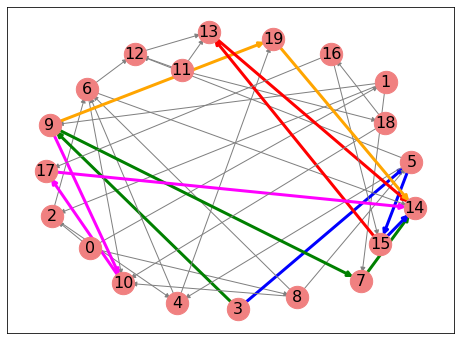

14


In [148]:
#G_dag, G_base, N, GOAL = costruisci_DAG(20, 5, 0.5, 5)

plt.figure(figsize=(8, 6))

pid = 0
path_color = {}
paths = [[3,5,15,14], [3,5,15,13,14], [3,9,7,14], [3,9,19,14], [3,9,10,17,14]]
edges_in_path = {}
path_color[0] = 'blue'
path_color[1] = 'red'
path_color[2] = 'green'
path_color[3] = 'orange'
path_color[4] = 'magenta'

for path in paths:
    for n in range(len(path)-1):
        edge = (path[n], path[n+1])
        if edge not in edges_in_path:
            edges_in_path[edge] = pid
    pid += 1

labels = {}
for n in G_dag.nodes:
    labels[n]= str(n)

pos = nx.spring_layout(G_dag, 116)
nx.draw_networkx_nodes(G_dag, pos, node_color='lightcoral', node_size=500)
nx.draw_networkx_labels(G_dag,pos,labels,font_size=16)

for edge in G_dag.edges:
    if edge in edges_in_path:
        print(edge, path_color[edges_in_path[edge]])
        #edge_colors.append(path_color[edges_in_path[edge]])
        colore = path_color[edges_in_path[edge]]
        es=3
    else:
        #edge_colors.append('gray')
        colore = 'gray'
        es=1
    nx.draw_networkx_edges(G_dag, pos, edgelist=[edge], edge_color=colore, width=es)
                  

#nx.draw(G_dag, pos, with_labels=True, node_color='lightcoral', edge_color=edge_colors, node_size=500, font_size=15)
#nx.draw(G_dag, pos, with_labels=True, node_size=500, font_size=15)

#plt.title("Watts-Strogatz Graph")
plt.savefig('graph.pdf', format='pdf')
plt.show()

print(GOAL)

In [147]:
sim_time = 0

def costruisci_rete(G_dag, G_base, N, GOAL, source_node, QL_enabled = False):
    
    learning_rate = 0.9
    discount_factor = 0.9
    background_traffic_rate = 6
    queue_size = 1000
    link_capacity = 20
    prop_delay = 1
    target_flow_ID = 1234
    duration = 2
    packet_size = 1000
    burst_peak = 40
    burst_activity_ratio = 0.01
    burst_period = 0.3
    stats_period = 0.001
    burst_probability = 0.3
    
    sim_time = 0
    random.seed(1)
    
    simulation_environment = {}
    
    N = len(G_base.nodes)
    L = len(G_base.edges) * 2
    
    routers = {}
    sources = {}
    interfaces = {}
    links = {}
    
    lid_src = 10000
    lid = 0
    
    for r in range(N):
        routers[r] = Router(r)
        sources['source_' + str(r)] = Interface(None, 'source_' + str(r), background_traffic_rate, 10000)
        Link(routers[r], sources['source_' + str(r)], 0, lid_src)
        lid_src += 1
        
    for edge in G_base.edges:
        interface_1_name = str(edge[0]) + "_" + str(edge[1])
        interface_2_name = str(edge[1]) + "_" + str(edge[0])
        interfaces[interface_1_name] = Interface(routers[edge[0]], interface_1_name, link_capacity, queue_size)
        Link(routers[edge[1]], interfaces[interface_1_name], prop_delay, lid)
        links[edge] = lid
        lid += 1
        interfaces[interface_2_name] = Interface(routers[edge[1]], interface_2_name, link_capacity, queue_size)
        Link(routers[edge[0]], interfaces[interface_2_name], prop_delay, lid)
        reverse_edge = (edge[1], edge[0])
        links[reverse_edge] = lid
        lid += 1
        
    DAG_goal = []

    for edge in G_dag.edges:
        DAG_goal.append(links[edge])
    
        
    DAGs = {GOAL : DAG_goal}
    
    for r in G_dag.nodes:
        agent = QLA(routers[r], N, L, DAGs, learning_rate, discount_factor)
        routers[r].set_QL_agent(agent)
    
    for s in G_base.nodes:
        for d in G_base.nodes:
            if s == d:
                routers[s].routingTable[d] = 'local'
            elif s != d:
                path = nx.shortest_path(G_base, source=s, target=d, weight='weight')
                interface_name = str(path[0]) + "_" + str(path[1])
                routers[s].routingTable[d] = interfaces[interface_name]
    
    if QL_enabled:
        for r in G_base.nodes:
            if r != GOAL:
                routers[r].routingTable[GOAL] = 'QL'
    
    log_GOAL = Log('GOAL_log')
    routers[GOAL].addLogFile(log_GOAL)
    
    scheduler = Scheduler()
    
    fid = 100
    
    for edge in G_base.edges:
        destination = edge[1]
        source = "source_" + str(edge[0])
        TrafficGenerator(fid, destination, sources[source], duration, packet_size, 0, scheduler)
        fid += 1
        destination = edge[0]
        source = "source_" + str(edge[1])
        TrafficGenerator(fid, destination, sources[source], duration, packet_size, 0, scheduler)
        fid += 1
    
    TrafficGenerator(target_flow_ID, GOAL, sources[source], duration, packet_size, 0.1, scheduler)
    monitored_interfaces = []
    
    path = nx.shortest_path(G_base, source_node, GOAL, weight='weight')
    edges_in_path = []
    
    for n in range(len(path) - 1):
        edge = (path[n], path[n+1])
        if random.random() > burst_probability:
            edges_in_path.append(edge)
            interface_name = str(edge[0]) + "_" + str(edge[1])
            monitored_interfaces.append(interfaces[interface_name])
            destination = edge[1]
            burst = Interface(None, "burst" + str(edge[0]), burst_peak, 10000)
            Link(routers[edge[0]], burst, 0, lid)
            lid += 1
            TrafficBurst(fid, edge[1], burst, burst_activity_ratio, burst_period, duration, packet_size, random.random(), scheduler)
            fid += 1
    print(edges_in_path)
        
    
    #(self, flow_ID, destination, source, activity_ratio, period, duration, packet_size, start_time, scheduler)
    #for edge in G_dag.edges:
    #    if random.random() > burst_probability:
    #        interface_name = str(edge[0]) + "_" + str(edge[1])
    #        monitored_interfaces.append(interfaces[interface_name])
    #        destination = edge[1]
    #        burst = Interface(None, "burst" + str(edge[0]), burst_peak, 10000)
    #        Link(routers[edge[0]], burst, 0, lid)
    #        lid += 1
    #        TrafficBurst(fid, 1, burst, burst_activity_ratio, burst_period, duration, packet_size, random.random(), scheduler)
    #        fid += 1
    
    collector = statsCollector("DAG_ifaces_stats", monitored_interfaces, stats_period, duration, scheduler)
    
    simulation_environment['scheduler'] = scheduler
    simulation_environment['collector'] = collector
    simulation_environment['routers'] = routers
    simulation_environment['interfaces'] = interfaces
    simulation_environment['log'] = log_GOAL
    
    return simulation_environment

In [70]:
sim_time = 0
random.seed(1)

if __name__ == '__main__':

    learning_rate = 0.9
    discount_factor = 0.9
    N = 4
    L = 10
    
    #(self, name)
    R0 = Router(0)
    R1 = Router(1)
    R2 = Router(2)
    R3 = Router(3)
    
    #(self, router, name, rate, queue_size)
    source0 = Interface(None, 'source0', 6, 10000)
    source1 = Interface(None, 'source1', 6, 10000)
    source2 = Interface(None, 'source2', 6, 10000)
    source3 = Interface(None, 'source3', 6, 10000)
    
    source01 = Interface(None, 'source01', 40, 10000)
    source02 = Interface(None, 'source02', 40, 10000)
    source13 = Interface(None, 'source13', 40, 10000)
    source23 = Interface(None, 'source23', 40, 10000)
    source12 = Interface(None, 'source12', 20, 10000)
    
    source_target_0 = Interface(None, 'source_target_0', 1, 10000)
    source_target_1 = Interface(None, 'source_target_1', 1, 10000)
    source_target_2 = Interface(None, 'source_target_2', 1, 10000)
    
    #(self, head, tail, delay, linkID)
    lA = Link(R0, source0, 0, 110000)
    lB = Link(R1, source1, 0, 120000)
    lC = Link(R2, source2, 0, 130000)
    lD = Link(R3, source3, 0, 140000)
    
    lE = Link(R0, source01, 0, 150000)
    lG = Link(R0, source02, 0, 150000)
    lH = Link(R1, source13, 0, 150000)
    lI = Link(R2, source23, 0, 150000)
    
    lF = Link(R0, source_target_0, 0, 150000)
    lM = Link(R1, source_target_1, 0, 150000)
    lN = Link(R2, source_target_2, 0, 150000)
    lO = Link(R1, source12, 0, 150000)
    
    #(self, router, name, rate, queue_size)
    R0_R1 = Interface(R0, 'R0_R1', 20, 1000)
    R1_R0 = Interface(R1, 'R1_R0', 20, 1000)
    R0_R2 = Interface(R0, 'R0_R2', 20, 1000)
    R2_R0 = Interface(R2, 'R2_R0', 20, 1000)
    R1_R2 = Interface(R1, 'R1_R2', 20, 1000)
    R2_R1 = Interface(R2, 'R2_R1', 20, 1000)
    R1_R3 = Interface(R1, 'R1_R3', 20, 1000)
    R3_R1 = Interface(R3, 'R3_R1', 20, 1000)
    R2_R3 = Interface(R2, 'R2_R3', 20, 1000)
    R3_R2 = Interface(R3, 'R3_R2', 20, 1000)
    
    #(self, head, tail, delay, linkID)
    l0 = Link(R1, R0_R1, 1, 0)
    l1 = Link(R0, R1_R0, 1, 1)
    l2 = Link(R2, R0_R2, 1, 2)
    l3 = Link(R0, R2_R0, 1, 3)
    l4 = Link(R2, R1_R2, 1, 4)
    l5 = Link(R1, R2_R1, 1, 5)
    l6 = Link(R3, R1_R3, 1, 6)
    l7 = Link(R1, R3_R1, 1, 7)
    l8 = Link(R3, R2_R3, 1, 8)
    l9 = Link(R2, R3_R2, 1, 9)
    
    DAG_3 = [0, 2, 4, 6, 8]
    DAG_2 = [0, 2, 4, 7, 9]
    DAG_1 = [0, 3, 5, 7, 9]
    DAG_0 = [1, 3, 5, 7, 9]
    
    DAGs = {0:DAG_0, 1:DAG_1, 2:DAG_2, 3:DAG_3}
    
    #(self, router, N, L, DAGs, learning_rate, discount_factor)
    agent0 = QLA(R0, N, L, DAGs, learning_rate, discount_factor)
    agent1 = QLA(R1, N, L, DAGs, learning_rate, discount_factor)
    agent2 = QLA(R2, N, L, DAGs, learning_rate, discount_factor)
    agent3 = QLA(R3, N, L, DAGs, learning_rate, discount_factor)
    
    R0.set_QL_agent(agent0)
    R1.set_QL_agent(agent1)
    R2.set_QL_agent(agent2)
    R3.set_QL_agent(agent3)
    
    QL_enabled = True
  
    
    R0.routingTable[0] = 'local'
    R0.routingTable[1] = R0_R1
    R0.routingTable[2] = R0_R2
    
    R1.routingTable[1] = 'local'
    R1.routingTable[0] = R1_R0
    R1.routingTable[2] = R1_R2
    #R1.routingTable[1234] = R1_R3
    
    R2.routingTable[2] = 'local'
    R2.routingTable[0] = R2_R0
    R2.routingTable[1] = R2_R1
    
    R3.routingTable[3] = 'local'
    R3.routingTable[0] = R3_R2
    R3.routingTable[1] = R3_R1
    R3.routingTable[2] = R3_R2
    
    if QL_enabled:
        R0.routingTable[3] = 'QL'
        R1.routingTable[3] = 'QL'
        R2.routingTable[3] = 'QL'
    else:
        R2.routingTable[3] = R2_R3
        R1.routingTable[3] = R1_R3
        R0.routingTable[3] = R0_R1
    
    log_0 = Log('R0_log')
    R0.addLogFile(log_0)
    log_1 = Log('R1_log')
    R1.addLogFile(log_1)
    log_2 = Log('R2_log')
    R2.addLogFile(log_2)
    log_3 = Log('R3_log')
    R3.addLogFile(log_3)
    
    scheduler = Scheduler()

    #tg = TG_pcap('piccolo.csv', src_R1, scheduler, 4, 1, 1.5, 0, [])
    #tg1 = TG_pcap('piccolo.csv', src_R1, scheduler, 8, 1, 1, 0.5, ['1','2','3','4','5'])
    #tg = TG_pcap('traccia_mawi.csv', src_R1, scheduler, 6, 1, 0.3)
    print("INIZIO")
    #tg = TrafficGenerator(1, src_R1, 2, 1000, scheduler)
    #tg = TrafficBurst(1, src_R1, 0.25, 1, 3, 1000, scheduler)
    
    #(flow_ID, destination, source, duration, packet_size, start_time, scheduler)
    tg1 = TrafficGenerator(100, 1, source0, 10, 1000, 0, scheduler)
    tg2 = TrafficGenerator(200, 2, source0, 10, 1000, 0.1, scheduler)
    tg10 = TrafficGenerator(1100, 0, source1, 10, 1000, 0.15, scheduler)
    tg12 = TrafficGenerator(1122, 2, source1, 10, 1000, 0.2, scheduler)
    tg13 = TrafficGenerator(1133, 3, source1, 10, 1000, 0.25, scheduler)
    tg20 = TrafficGenerator(2200, 0, source2, 10, 1000, 0.3, scheduler)
    tg21 = TrafficGenerator(2211, 1, source2, 10, 1000, 0.35, scheduler)
    tg23 = TrafficGenerator(2233, 3, source2, 10, 1000, 0.4, scheduler)
    tg31 = TrafficGenerator(3311, 1, source3, 10, 1000, 0.45, scheduler)
    tg32 = TrafficGenerator(3322, 2, source3, 10, 1000, 0.5, scheduler)
    
    #(flow_ID, destination, source, activity_ratio, period, duration, packet_size, start_time, scheduler)
    tg_congestion = TrafficGenerator(1234, 2, source12, 7, 1000, 3, scheduler)
    #tg_congestion_1 = TrafficBurst(1234, 1, source01, 0.1, 0.5, 10, 1000, 0, scheduler)
    #tg_congestion_2 = TrafficBurst(1234, 2, source02, 0.1, 0.3, 10, 1000, 0, scheduler)
    #tg_congestion_3 = TrafficBurst(1234, 3, source13, 0.1, 0.7, 10, 1000, 0, scheduler)
    #tg_congestion_4 = TrafficBurst(1234, 3, source23, 0.1, 1.1, 10, 1000, 0, scheduler)
    
    tg_target_0 = TrafficGenerator(4320, 3, source_target_0, 9, 1000, 1, scheduler)
    #tg_target_1 = TrafficGenerator(4321, 3, source_target_1, 7, 1000, 1, scheduler)
    #tg_target_2 = TrafficGenerator(4322, 3, source_target_2, 7, 1000, 1, scheduler)
    
    #(self, file_name, list_of_devices, period, duration, scheduler)
    collector = statsCollector("1_ms_stats", [R1_R2], 0.001, 10, scheduler)
    
    scheduler.run()
    
    log_0.stampa_su_file()
    log_1.stampa_su_file()
    log_2.stampa_su_file()
    log_3.stampa_su_file()
    collector.stampaSuFile()
    
    print("FINE")

INIZIO
FINE


In [51]:
global sim_time
sim_time = 0

source_node = 3
QL_enabled = True
path_0 = [3,5,15,14,] #None
    
learning_rate = 0.9
discount_factor = 0.9
background_traffic_rate = 1
queue_size = 1000
link_capacity = 20
prop_delay = 1
target_flow_ID = 1234
duration = 2
packet_size = 1000
burst_peak = 60
burst_activity_ratio = 0.15
burst_period = 0.4
stats_period = 0.001
    
random.seed(1)
    
simulation_environment = {}
    
N = len(G_base.nodes)
L = len(G_base.edges) * 2
    
routers = {}
sources = {}
interfaces = {}
links = {}
    
lid_src = 10000
lid = 0
    
for r in range(N):
    routers[r] = Router(r)
    sources['source_' + str(r)] = Interface(None, 'source_' + str(r), background_traffic_rate, 10000)
    Link(routers[r], sources['source_' + str(r)], 0, lid_src)
    lid_src += 1
        
for edge in G_base.edges:
    interface_1_name = str(edge[0]) + "_" + str(edge[1])
    interface_2_name = str(edge[1]) + "_" + str(edge[0])
    interfaces[interface_1_name] = Interface(routers[edge[0]], interface_1_name, link_capacity, queue_size)
    Link(routers[edge[1]], interfaces[interface_1_name], prop_delay, lid)
    links[edge] = lid
    lid += 1
    interfaces[interface_2_name] = Interface(routers[edge[1]], interface_2_name, link_capacity, queue_size)
    Link(routers[edge[0]], interfaces[interface_2_name], prop_delay, lid)
    reverse_edge = (edge[1], edge[0])
    links[reverse_edge] = lid
    lid += 1
        
DAG_goal = []

for edge in G_dag.edges:
    DAG_goal.append(links[edge])
    
        
DAGs = {GOAL : DAG_goal}
    
for r in G_dag.nodes:
    agent = QLA(routers[r], N, L, DAGs, learning_rate, discount_factor)
    routers[r].set_QL_agent(agent)
    
for s in G_base.nodes:
    for d in G_base.nodes:
        if s == d:
            routers[s].routingTable[d] = 'local'
        elif s != d:
            path = nx.shortest_path(G_base, source=s, target=d, weight='weight')
            interface_name = str(path[0]) + "_" + str(path[1])
            routers[s].routingTable[d] = interfaces[interface_name]
    
if QL_enabled:
    for r in G_base.nodes:
        if r != GOAL:
            routers[r].routingTable[target_flow_ID] = 'QL'
else:
    if path_0 != None:
        for i in range(len(path_0) - 1):
            interface_name = str(path_0[i]) + "_" + str(path_0[i + 1])
            routers[path_0[i]].routingTable[target_flow_ID] = interfaces[interface_name]
    
    
log_GOAL = Log('GOAL_log')
routers[GOAL].addLogFile(log_GOAL)
    
scheduler = Scheduler()
    
fid = 100
    
for edge in G_base.edges:
    destination = edge[1]
    source = "source_" + str(edge[0])
    TrafficGenerator(fid, destination, sources[source], duration, packet_size, 0, scheduler)
    fid += 1
    destination = edge[0]
    source = "source_" + str(edge[1])
    TrafficGenerator(fid, destination, sources[source], duration, packet_size, 0, scheduler)
    fid += 1
    
TrafficGenerator(target_flow_ID, GOAL, sources["source_" + str(source_node)], duration, packet_size, 0.1, scheduler)
monitored_interfaces = []
monitored_interfaces_names = []
    
path = nx.shortest_path(G_base, source_node, GOAL, weight='weight')
print(path)
edges_in_path = []
    
edge = (path[-2], path[-1])
edges_in_path.append(edge)
interface_name = str(edge[0]) + "_" + str(edge[1])
monitored_interfaces.append(interfaces[interface_name])
monitored_interfaces_names.append(interface_name)
destination = edge[1]
burst = Interface(None, "burst" + str(edge[0]), burst_peak, 10000)
Link(routers[edge[0]], burst, 0, lid)
lid += 1
TrafficBurst(fid, edge[1], burst, burst_activity_ratio, burst_period, duration, packet_size, random.random(), scheduler)
fid += 1
        
    
#(self, flow_ID, destination, source, activity_ratio, period, duration, packet_size, start_time, scheduler)
for edge in G_dag.edges:
    if edge[1] == GOAL and edge not in edges_in_path:
        print(str(edge[0]) + "_" + str(edge[1]))
        interface_name = str(edge[0]) + "_" + str(edge[1])
        monitored_interfaces.append(interfaces[interface_name])
        monitored_interfaces_names.append(interface_name)
        destination = edge[1]
        burst = Interface(None, "burst" + str(edge[0]), burst_peak, 10000)
        Link(routers[edge[0]], burst, 0, lid)
        lid += 1
        random_start_time = random.random()
        print(random_start_time)
        TrafficBurst(fid, destination, burst, burst_activity_ratio, burst_period, duration, packet_size, random_start_time, scheduler)
        fid += 1
    
collector = statsCollector("DAG_ifaces_stats", monitored_interfaces, stats_period, duration + 0.5, scheduler)
    
simulation_environment['scheduler'] = scheduler
simulation_environment['collector'] = collector
simulation_environment['routers'] = routers
simulation_environment['interfaces'] = interfaces
simulation_environment['log'] = log_GOAL
    
simulation_environment['scheduler'].run()
simulation_environment['log'].stampa_su_file()
simulation_environment['collector'].stampaSuFile()

[3, 5, 15, 14]
6_14
0.8474337369372327
7_14
0.763774618976614
13_14
0.2550690257394217
17_14
0.49543508709194095
19_14
0.4494910647887381


commenti generali: aumentare il rate (10 Gbps), diminuire il ritardo di propagazione, usare reti SNDlib

Analisi stabilità: inserire una singola perturbazione e mostrare il numero complessivo di re-instradamenti
ripetere l'analisi al crescere del rate del flusso spostato

In [26]:
G_dag, G_base, N, GOAL = DAG_da_SNDlib("abilene", 5)

1_0
0_1
1_0
0_1
4_1
1_4
4_1
1_4
5_1
1_5
5_1
1_5
11_1
1_11
11_1
1_11
5_2
2_5
5_2
2_5
8_2
2_8
8_2
2_8
6_3
3_6
6_3
3_6
9_3
3_9
9_3
3_9
10_3
3_10
10_3
3_10
6_4
4_6
6_4
4_6
7_4
4_7
7_4
4_7
6_5
5_6
6_5
5_6
9_7
7_9
9_7
7_9
11_8
8_11
11_8
8_11
10_9
9_10
10_9
9_10
0
1
2
3
4
5
6
7
8
9
10
11


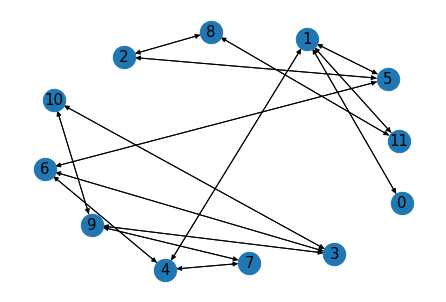

In [31]:
pos = nx.spring_layout(G_base, 116)
nx.draw(G_base, pos, with_labels=True, node_size=500, font_size=15)

In [28]:
G_base.edges

OutEdgeView([(0, 1), (1, 0), (1, 4), (1, 5), (1, 11), (2, 5), (2, 8), (3, 6), (3, 9), (3, 10), (4, 1), (4, 6), (4, 7), (5, 1), (5, 2), (5, 6), (6, 3), (6, 4), (6, 5), (7, 4), (7, 9), (8, 2), (8, 11), (9, 3), (9, 7), (9, 10), (10, 3), (10, 9), (11, 1), (11, 8)])